In [3]:
from tensorflow import keras

## Data import
import numpy as np
import mne

# EEGNet-specific imports
from tensorflow.keras import utils as np_utils
from keras import backend as K

In [4]:
folder_path_string = "BCICIV_2a_gdf/"

file_path_string = folder_path_string + "A01T.gdf"
evaluation_path_string = folder_path_string + "A01T.evt"

raws = []

In [5]:
# while the default tensorflow ordering is 'channels_last' we set it here
# to be explicit in case if the user has changed the default ordering
K.set_image_data_format('channels_last')

##################### Process, filter and epoch the data ######################
raw_fname = file_path_string
event_fname = evaluation_path_string
tmin, tmax = -0., 1

# Setup for reading the raw data
raw = mne.io.read_raw_gdf(raw_fname)
raw.load_data()

#original filter
raw.filter(2, None, method='iir')  # replace baselining with high-pass

events, event_ids = mne.events_from_annotations(raw)
event_id = events[1]
print("event_id ",event_id)
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False)

# Read epochs
stims =[value for key, value in event_ids.items() if key in ('769','770','771','772')]
epochs = mne.Epochs(raw, events, stims, tmin, tmax, proj=False,
                    picks=picks, baseline=None, preload=True, verbose=False)
channels_to_remove = ['EOG-left', 'EOG-central', 'EOG-right']
epochs = epochs.drop_channels(channels_to_remove)
labels = epochs.events[:, -1]
print(epochs)

# extract raw data. scale by 1000 due to scaling sensitivity in deep learning
X = epochs.get_data()*1000 # format is in (trials, channels, samples)
y = labels
y[y == 7] = 0
y[y == 8] = 1
y[y == 9] = 2
y[y == 10] = 3

kernels, chans, samples = 1, X.shape[1], X.shape[2]

# take 50/25/25 percent of the data to train/validate/test

train_idx = round(X.shape[0] * 0.5)
test_idx = round(X.shape[0] * 0.75)

X_train      = X[0:train_idx,]
Y_train      = y[0:train_idx]
X_validate   = X[train_idx:test_idx,]
Y_validate   = y[train_idx:test_idx]
X_test       = X[test_idx:,]
Y_test       = y[test_idx:]

############################# EEGNet portion ##################################

# convert labels to one-hot encodings.
y_unique = np.unique(y)
num_classes = len(y_unique)
Y_train      = np_utils.to_categorical(Y_train-1, num_classes=num_classes)
Y_validate   = np_utils.to_categorical(Y_validate-1, num_classes=num_classes)
Y_test       = np_utils.to_categorical(Y_test-1, num_classes=num_classes)

# convert data to NHWC (trials, channels, samples, kernels) format. Data
# contains 60 channels and 151 time-points. Set the number of kernels to 1.
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)

print("X.Shape", X.shape)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print("y.Shape", y.shape)
print('y_train shape:', Y_train.shape)
print('y_test shape:', Y_test.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print('num_classes:', num_classes)

Extracting EDF parameters from /home/jovyan/work/BCICIV_2a_gdf/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/opt/conda/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/opt/conda/lib/python3.9/contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 2 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 2.00 Hz: -6.02 dB

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
event_id  [0 0 3]
<Epochs |  288 events (all good), 0 - 1 sec, baseline off, ~12.2 MB, data loaded,
 '7': 72
 '8': 72
 '9': 72
 '10': 72>
X.Shape (288, 22, 251)
X_train shape: (144, 22, 251, 1)
X_test shape: (72, 22, 251, 1)
y.Shape (288,)
y_train shape: (144, 4)
y_test shape: (72, 4)
144 train samples
72 test samples
num_classes: 4


In [6]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [7]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = keras.layers.GlobalAveragePooling2D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = keras.layers.Dense(dim, activation="relu")(x)
        x = keras.layers.Dropout(mlp_dropout)(x)
    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

## Train and evaluate

2022-06-27 23:51:49.641264: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-27 23:51:51.408139: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 149 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:01:00.0, compute capability: 7.5
2022-06-27 23:51:51.410445: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46571 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:25:00.0, compute capability: 7.5
2022-06-27 23:51:51.412903: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 

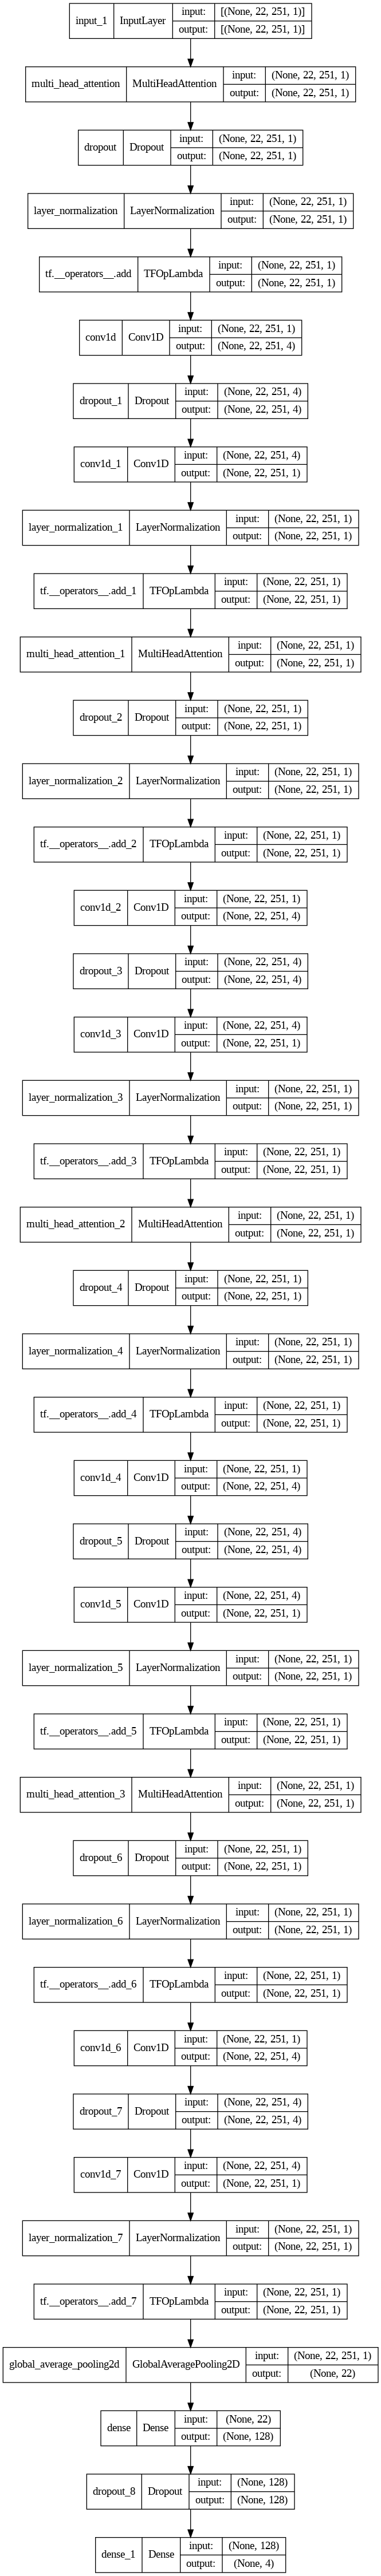

In [8]:
input_shape = X_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

keras.utils.plot_model(model, show_shapes=True)

In [9]:
'''model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)'''
# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics = ['accuracy', 'TruePositives', 'TrueNegatives'])
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 22, 251, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 multi_head_attention (MultiHea  (None, 22, 251, 1)  7169        ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 22, 251, 1)   0           ['multi_head_attention[0][0]']   
                                                                                              

In [10]:
model.fit(
    X_train,
    Y_train,
    validation_split=0.2,
    epochs=2,
    batch_size=64,
    callbacks=callbacks,
)

model.evaluate(X_test, Y_test, verbose=1)

Epoch 1/2


2022-06-27 23:52:13.488837: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.35GiB (rounded to 1447559168)requested by op model/multi_head_attention/key/einsum/Einsum
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-06-27 23:52:13.488924: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-06-27 23:52:13.488946: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 170, Chunks in use: 170. 42.5KiB allocated for chunks. 42.5KiB in use in bin. 1.4KiB client-requested in use in bin.
2022-06-27 23:52:13.488960: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 4, Chunks in use: 4. 2.0KiB allocated for chunks. 2.0KiB in use in bin. 2.0KiB client-requested in use in b

ResourceExhaustedError: 2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[353408,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/multi_head_attention/key/einsum/Einsum
 (defined at /opt/conda/lib/python3.9/site-packages/keras/layers/einsum_dense.py:187)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[assert_greater_equal/Assert/AssertGuard/pivot_f/_3/_61]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[353408,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/multi_head_attention/key/einsum/Einsum
 (defined at /opt/conda/lib/python3.9/site-packages/keras/layers/einsum_dense.py:187)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_7715]

Errors may have originated from an input operation.
Input Source operations connected to node model/multi_head_attention/key/einsum/Einsum:
In[0] IteratorGetNext (defined at /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:866)	
In[1] model/multi_head_attention/key/einsum/Einsum/ReadVariableOp:

Operation defined at: (most recent call last)
>>>   File "/opt/conda/lib/python3.9/runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/opt/conda/lib/python3.9/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/opt/conda/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/opt/conda/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "/opt/conda/lib/python3.9/asyncio/events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 450, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
>>>     await result
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 652, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2768, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2814, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3012, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
>>>     if await self.run_code(code, result, async_=asy):
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3251, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_57960/47143056.py", line 1, in <module>
>>>     model.fit(
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/layers/multi_head_attention.py", line 498, in call
>>>     key = self._key_dense(key)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/layers/einsum_dense.py", line 187, in call
>>>     ret = tf.einsum(self.equation, inputs, self.kernel)
>>> 

Input Source operations connected to node model/multi_head_attention/key/einsum/Einsum:
In[0] IteratorGetNext (defined at /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:866)	
In[1] model/multi_head_attention/key/einsum/Einsum/ReadVariableOp:

Operation defined at: (most recent call last)
>>>   File "/opt/conda/lib/python3.9/runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/opt/conda/lib/python3.9/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/opt/conda/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/opt/conda/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "/opt/conda/lib/python3.9/asyncio/events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 450, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
>>>     await result
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 652, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2768, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2814, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3012, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
>>>     if await self.run_code(code, result, async_=asy):
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3251, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_57960/47143056.py", line 1, in <module>
>>>     model.fit(
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/layers/multi_head_attention.py", line 498, in call
>>>     key = self._key_dense(key)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/layers/einsum_dense.py", line 187, in call
>>>     ret = tf.einsum(self.equation, inputs, self.kernel)
>>> 

Function call stack:
train_function -> train_function
